In [6]:
# 1. Coin Flip Example
#Import required libraries :
import math
import random
import numpy as np

import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
# import PillowWriter
from matplotlib.animation import PillowWriter

from matplotlib.animation import FuncAnimation
# import pymc as pm

%matplotlib inline

In [18]:
# Descrete Distributions
# To get PMF from CDF : 
# P(X = k) = P(X <= k) - P(X <= k - 1)

# E(x) = sum(x * P(X = x))
# Var(x) = E(x^2) - E(x)^2

def bernoulli_pmf(k, p):
    # k is numer of successes
    # p is probability of success
    return p ** k * (1 - p) ** (1 - k)

def bernoulli_cdf(k, p):
    # sum of pmf from 0 to k
    # k is inclusive
    return sum([bernoulli_pmf(i, p) for i in range(k + 1)])

def bernoulli_rv(p):
    return random.choices([0, 1], weights=[1 - p, p])[0]


def plot_bernoulli(p):
    x = np.arange(0, 2, 1)
    y = [bernoulli_pmf(i, p) for i in x]

    plt.bar(x, y)
    plt.title('Bernoulli PMF')
    plt.xlabel('k')
    plt.ylabel('P(X = k)')
    plt.show()


def binomial_pmf(k, n, p):
    # k is number of successes
    # n is number of trials
    # p is probability of success
    # n chosen k
    n_choose_k = math.factorial(n) / (math.factorial(k) * math.factorial(n - k))

    return n_choose_k * (p ** k) * ((1 - p) ** (n - k))

def binomial_cdf(k, n, p):
    # sum of pmf from 0 to k
    # k is inclusive
    # n is number of trials
    # p is probability of success
    return sum([binomial_pmf(i, n, p) for i in range(k + 1)])


def binom_rv(n, p):
    
    return sum(random.choices([0, 1], weights=[1 - p, p], k=n))


def plot_binomial(n, p):
    x = np.arange(0, n + 1, 1)
    y = [binomial_pmf(i, n, p) for i in x]

    plt.bar(x, y)
    plt.title('Binomial PMF')
    plt.xlabel('k')
    plt.ylabel('P(X = k)')
    plt.show()

def geometric_pmf(k, p):
    # k is number of failures
    # p is probability of success
    return (1 - p) ** (k - 1) * p

def geometric_cdf(k, p):
    # sum of pmf from 0 to k
    # k is inclusive
    return sum([geometric_pmf(i, p) for i in range(k + 1)])

def geometric_rv(p):
    return random.choices(range(1, 1000), weights=[geometric_pmf(i, p) for i in range(1, 1000)])[0]

def poisson_pmf(k, l):
    # k is number of events
    # l is rate of events
    return (l ** k) * (math.e ** (-l)) / math.factorial(k)

def poisson_cdf(k, l):
    # sum of pmf from 0 to k
    # k is inclusive
    return sum([poisson_pmf(i, l) for i in range(k + 1)])

def poisson_rv(l):
    return random.choices(range(0, 1000), weights=[poisson_pmf(i, l) for i in range(0, 1000)])[0]



In [28]:
# Continuous Distributions
# To get PDF from CDF : f(x) = F'(x)

# to get CDF : F(x) = integral(f(x) dx)

# E(x) = integral(x * f(x) dx)
# Var(x) = integral(x^2 * f(x) dx) - E(x)^2

def uniform_pdf(x, a, b):
    # x is a random variable
    # a is lower bound
    # b is upper bound
    if a <= x <= b:
        return 1 / (b - a)
    else:
        return 0

def uniform_cdf(x, a, b):
    # x is a random variable
    # a is lower bound
    # b is upper bound
    if x < a:
        return 0
    elif x < b:
        return (x - a) / (b - a)
    else:
        return 1

def uniform_rv(a, b):
    return random.uniform(a, b)

def uniform_mean(a, b):
    return (a + b) / 2

def uniform_variance(a, b):
    return (b - a) ** 2 / 12

def plot_uniform(a, b):
    x = np.linspace(a, b, 1000)
    y = [uniform_pdf(i, a, b) for i in x]
    plt.plot(x, y)
    plt.show()


def normal_pdf(x, mu, sigma):
    # x is a random variable
    # mu is mean
    # sigma is standard deviation
    return (1 / (sigma * math.sqrt(2 * math.pi))) * (math.e ** (-((x - mu) ** 2) / (2 * sigma ** 2)))

def normal_cdf(x, mu, sigma):
    # x is a random variable
    # mu is mean
    # sigma is standard deviation

    # returned derivative of normal pdf with respect to x
    return (1 + math.erf((x - mu) / (sigma * math.sqrt(2)))) / 2

def normal_rv(mu, sigma):
    return random.normalvariate(mu, sigma)

def plot_normal(mu, sigma):
    x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 1000)
    y = [normal_pdf(i, mu, sigma) for i in x]
    plt.plot(x, y)
    plt.show()

def plot_normal_cdf(mu, sigma):
    x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 1000)
    y = [normal_cdf(i, mu, sigma) for i in x]
    plt.plot(x, y)
    plt.show()


In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

fruits = ['apple', 'blueberry', 'cherry', 'orange']
counts = [40, 100, 30, 55]
bar_labels = ['red', 'blue', '_red', 'orange']
bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange']

ax.bar(fruits, counts, label=bar_labels, color=bar_colors)

ax.set_ylabel('fruit supply')
ax.set_title('Fruit supply by kind and color')
ax.legend(title='Fruit color')

plt.show()

In [ ]:

ax, fig = plt.subplots(1, 1)
x = np.linspace(0, 10, 20)
y = [uniform_pdf(i, 1, 10) for i in x]


In [ ]:
rvars_manual = [binom_rv(10, 0.5) for i in range(10)]

rvars_manual

In [31]:
def coin_flip():
    return random.randint(0,1)

def roll_dice():
    return random.randint(1,6)



In [32]:
def coin_flip_experiment(n):

    # Initial assumptions for the experiment
    # 1. The coin is fair
    # 2. The coin is tossed n times
    # 3. The coin is tossed independently of each other
    # 4. Bernoulli distribution is used to simulate the coin toss

    events = sp.stats.bernoulli.rvs(p=0.5, size=n, random_state=42)
    res = 0
    prob = []
    std_dev = []
    variences = []

    for inx, event in enumerate(events):
        res = res + event
        prob_ = res / (inx + 1)
        prob.append(prob_)
        variences.append(prob_ * (1 - prob_))
        std_dev.append(np.sqrt(prob_ * (1 - prob_)))


    # Plotting the results
    fig, ax = plt.subplots()
    ax.set_ylim(-0.2, 1)
    ax.set_xlim(0, len(prob))
    ax.set_xlabel('Number of simulations')
    ax.set_ylabel('Probability')

    line, = ax.plot([], [], lw=2, label='Probability / E(x)')
    std_dev_line, = ax.plot([], [], lw=2, color='red', label='Standard Deviation')
    variences_line, = ax.plot([], [], lw=2, color='green', label='Variance')

    # Animation function
    def prob_update(num):
        x = range(0, num)
        mean_ = prob[:num]
        std_dev_ = std_dev[:num]
        var_ = variences[:num]
        line.set_data(x, mean_)
        std_dev_line.set_data(x, std_dev_)
        variences_line.set_data(x, var_)
        return line, std_dev_line

    ax.legend()
    anim = FuncAnimation(fig, prob_update, frames=np.arange(1, len(prob)+1), repeat=False)
    plt.xlabel('Number of coin flips')
    plt.ylabel('Probability of getting heads')
    plt.title('Coin Flip Simulation')
    anim.save('coin_flip.gif', writer=PillowWriter(fps=10))

    return events, prob, std_dev, variences

def coin_flip_experiment_all(n, iters):

    # Initial assumptions for the experiment
    # 1. The coin is fair
    # 2. The coin is tossed n times
    # 3. The coin is tossed independently of each other
    # 4. Bernoulli distribution is used to simulate the coin toss

    def coin_experiment(nums):
        events = sp.stats.bernoulli.rvs(p=0.5, size=nums)
        res = 0
        prob = []
        std_dev = []
        variences = []

        for inx, event in enumerate(events):
            res = res + event
            prob_ = res / (inx + 1)
            prob.append(prob_)
            variences.append(prob_ * (1 - prob_))
            std_dev.append(np.sqrt(prob_ * (1 - prob_)))
        return prob

    
    # Animation function
    def prob_update(num, experiments, lines):
        for experiment, line in zip(experiments, lines):
            x = range(0, num)
            mean_ = experiment[:num]
            line.set_data(x, mean_)
        return lines


    experiments = [coin_experiment(n) for i in range(iters)]

    # Plotting the results
    fig, ax = plt.subplots()
    ax.set_ylim(0, 1)
    ax.set_xlim(0, n)
    ax.set_xlabel('Number of simulations')
    ax.set_ylabel('Probability')

    lines = [ax.plot([], [], lw=2)[0] for _ in experiments]

    ax.legend()

    anim = FuncAnimation(fig, prob_update, n, fargs=(experiments, lines), repeat=False)
    plt.xlabel('Number of coin flips')
    plt.ylabel('Probability of getting heads')
    plt.title('Coin Flip Simulation')
    anim.save('coin_flip.gif', writer=PillowWriter(fps=20))

    return experiments






In [ ]:
expts = coin_flip_experiment_all(3000, 100)

In [ ]:
# MC simulation
prob_list = []
def monte_carlo(n):
    # n = number of simulations
    # x = number of heads
    results = 0
    for i in range(n):
        flip_result = coin_flip()
        # print("Coin result on experiment {}: {} ".format(i,flip_result))
        results = results + flip_result 
        # print("Total number of heads: {}".format(results))      

        prob_value = results/ (i+1)
        # print("Probability of heads: {}".format(prob_value))
        prob_list.append(prob_value)

        # plot the results
        plt.axhline(y=0.5, color='red', linestyle='dashed')
        plt.xlabel('Number of simulations')
        plt.ylabel('Probability')
        plt.title('Monte Carlo Simulation')
        plt.plot(prob_list)
    return prob_value/n
    

"""Algos
Given a set of coin flip data, you can estimate the distribution parameters (in this case, the probability of getting heads)
 using maximum likelihood estimation (MLE). MLE is a method for estimating the parameters of a statistical model given a set of data."""



 Method of Moments (MOM): This method estimates the parameters of a distribution by equating the sample moments (i.e., mean, variance, skewness, etc.) to the theoretical moments of the distribution.

Maximum a posteriori estimation (MAP): This method is similar to MLE, but it incorporates prior information about the parameters into the estimation process. It uses Bayes' theorem to find the parameter values that maximize the posterior probability distribution.

Bayesian estimation: This method is based on Bayesian statistics and uses prior information about the parameters in combination with the data to estimate the parameters. It allows for the calculation of the probability distribution of the parameters rather than a single point estimate.

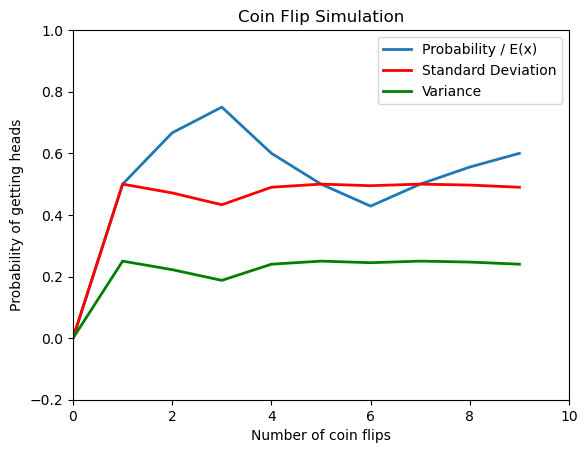

In [82]:
coin_data_5, p, st, v  = coin_flip_experiment(10)


In [83]:
n = len(coin_data_5)
k = sum(coin_data_5)

def likelihood(p):
    return p**k * (1-p)**(n-k)


print(likelihood(0.5))

prior_p = 0.5

result = sp.optimize.minimize(lambda p: -likelihood(p), prior_p, method='Nelder-Mead')

0.0009765625


In [86]:
result

 final_simplex: (array([[0.6       ],
       [0.59990234]]), array([-0.00119439, -0.00119439]))
           fun: -0.0011943936
       message: 'Optimization terminated successfully.'
          nfev: 22
           nit: 11
        status: 0
       success: True
             x: array([0.6])

In [67]:
p_est = result.x[0]
print("Estimated parameter p(mean):", p_est)
print("Estimated (std):", np.sqrt(p_est*(1-p_est)/n))
print("Estimated parameter std  :", result)

Estimated parameter p(mean): 0.47001953124999996
Estimated (std): 0.04991003621452606
Estimated parameter std  :  final_simplex: (array([[0.47001953],
       [0.46992187]]), array([-9.44540052e-31, -9.44538968e-31]))
           fun: -9.44540052483785e-31
       message: 'Optimization terminated successfully.'
          nfev: 20
           nit: 10
        status: 0
       success: True
             x: array([0.47001953])


In [68]:
observed = [k, n-k]
expected = [n*p_est, n*(1-p_est)]

In [45]:
# Chi-squared test
chisq, p_value = sp.stats.chisquare(observed, expected)
print("Chi-squared test statistic:", chisq)
print("p-value:", p_value)


Chi-squared test statistic: 2.9908322978911693e-06
p-value: 0.9986201372972393


In [72]:
#Kolmogorov-Smirnov test for bernoulli distribution

ks, p = sp.stats.kstest(coin_data_5, sp.stats.bernoulli.cdf,  args=(p_est,), alternative='less')


print("KS test statistic:", ks, alternative="two-sided")
print("p-value:", p)


TypeError: 'alternative' is an invalid keyword argument for print()

In [ ]:
def poisson_pmf(k, lam):
    # where k is the number of events
    
    return (lam ** k) * (math.e ** (-lam)) / math.factorial(k)


print("Poisson PMF: {}".format(poisson_pmf(1, 0.000008)))


In [ ]:
# average rate of button breakage
lam = 1/1000

# create a Poisson distribution object with the estimated lambda
poisson_dist = sp.stats.poisson(lam)

# calculate the probability mass function for a specific number of failures
k = 5
poisson_dist.pmf(k)

# generate random variables from the poisson distribution
poisson_dist.rvs(size=10)

In [ ]:
X_fails = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
lbda = 1/100

In [ ]:
poisson_pd = sp.stats.poisson.pmf(X_fails, lbda)


In [ ]:
for i in poisson_pd:
    print("{:.8f}".format(i))

In [ ]:
plt.hist(X_fails, bins=[1,2,3,4, 5], density=True)
plt.show()


In [ ]:
print(dice_experiment())

In [ ]:
# Gerald -> ask about Internal data

# Intervals instead of events 

# then assumption : all valves are same and collectors same

# All collectors overlaped 

In [ ]:
class Valve:
    def __init__(self, name, collector):
        self.name = name
        self.collector = collector
    def __repr__(self):
        return self.name

    @staticmethod
    def get_failure(dist='possion'):
        if dist == 'possion':
            return sp.stats.poisson.rvs(mu=600, loc=400)


class Collector:
    def __init__(self, name, valves):
        self.name = name
        self.valves = valves

    def __repr__(self):
        return self.name


In [ ]:
random.randint(30,100)

In [ ]:
valve_one = Valve('Valve 1', 'Collector 1')


In [ ]:
v_one_failures = []
v_two_failures = []
v_three_failures = []
v_four_failures = []
f_count = 0

In [ ]:

while f_count < 10000:

    valve_one_f = valve_one.get_failure()
    valve_two_f = valve_one.get_failure()
    valve_three_f = valve_one.get_failure()
    valve_four_f = valve_one.get_failure()

    f_count += min(valve_one_f, valve_two_f, valve_three_f, valve_four_f)
    print(f_count)
    
    one_before_f = np.zeros(f-1) 
    one_wait_f = np.ones(random.randint(50,200))

    v_one_ts = np.concatenate((one_before_f, one_wait_f))
    
    v_one_failures = np.concatenate((v_one_ts, v_one_failures))

In [ ]:
sp.stats.poisson.pmf(1, 1)

In [ ]:
poss_rvs = sp.stats.poisson.rvs(mu=500, loc=500, size=5000)

beta_dist = sp.stats.beta(a=0.7, b=0.3, loc=0, scale=100)

In [ ]:
xx = beta_dist.rvs(size=10)

In [ ]:
xx

In [ ]:
beta_dist.pdf(90)


In [ ]:
plt.hist(poss_rvs, bins='auto', density=True)
plt.show()

In [ ]:
one_half = np.zeros(f-1) 
second_half = np.ones(31)

valve_half = np.zeros(f2-1)
valve_half2 = np.ones(31)

xs = np.concatenate((one_half, second_half))
xss = np.concatenate((valve_half, valve_half2))

con_ = np.concatenate((xs, xss))

In [ ]:
fig,ax = plt.subplots(figsize=(10,4), sharex=True)
# title
fig.suptitle("Inactive Pulses for Machine ID - 83 with 24 valves")
ax.set_ylim([0, 8])
ax.set_ylabel("Failed Pulse", color="black", fontsize=10)
ax.plot(v_one_failures, color='green')


In [ ]:
o = np.ones(10)
b = np.ones(5)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def bathtub_pdf(t, λ1, λ2, λ3, t1, t2):
    if t < t1:
        return λ1*np.exp(-λ1*t)
    elif t1 <= t <= t2:
        return λ2
    elif t > t2:
        return λ3*np.exp(-λ3*t)
    else:
        return None

# Example usage:
t = np.linspace(0, 100, 100)
λ1, λ2, λ3 = 0.1, 0.01, 0.05
t1, t2 = 5, 15
y = [bathtub_pdf(x, λ1, λ2, λ3, t1, t2) for x in t]

plt.plot(t, y)
plt.title('Bathtub Failure Rate for Machine ID - 83 scaled down')
plt.xlabel('Time ~ Pulse ')
plt.ylabel('Failure Rate (λ)')
plt.show()


In [ ]:
np.linspace(0, 10)